In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, skewnorm
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"

# Central Limit Theorem

**Definition:** For i.i.d. random variables in a population with mean $\mu$ and finite variance $\sigma^2$, the (estimated) sample mean tend toward the standard normal distribution.

We attempt to test this theorem empirically with two variables with non-normal distributions (binomial and poisson) and one variable with normal distribution. We repeated sample from these populations and test the normality of the distribution of the sample means.


In [2]:
# Generate population distributions

rng = np.random.default_rng(seed=42)

pop_dict = {
    'binomial': rng.binomial(n=1, p=0.7, size=1000),
    # 'normal': rng.normal(loc=10, scale=1, size=1000),
    'normal': rng.standard_normal(size=1000),
    'poisson': rng.poisson(lam=2, size=1000)
    
}

In [3]:
def random_sampling(population: list, sample_count: int, sample_size: int):
    sample_mean = []
    i = 0
    while i < sample_count:     
        sample_mean.append(
            np.mean(np.random.choice(population, sample_count, replace=True))
        )
        i += 1
    return np.array(sample_mean)

In [4]:
def generate_sample_mean(pop_dict: dict, sample_count:int, sample_size: int):
    # initialize dict
    sample_mean_dict = dict()
    # randomly sample from each population distribution
    for key in pop_dict.keys():
        sample_mean_dict[key] = random_sampling(pop_dict[key], sample_count, sample_size)
    return sample_mean_dict

In [5]:
def norm_pdf(x: list):
    x = np.sort(x)
    mu = np.mean(x)
    sigma = np.std(x)
    pdf = 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-(x-mu)**2/(2*sigma**2))  
    return x, mu, sigma, pdf

In [6]:
def plot_histograms(dist_dict: dict, title: str):
    
    fig = make_subplots(
        rows=1, cols=len(dist_dict.keys()), 
        shared_yaxes=False,
        subplot_titles=tuple(dist_dict.keys())
    )

    i = 1
    for distribution in dist_dict.keys(): 
        x, mu, sigma, pdf = norm_pdf(dist_dict[distribution])
        fig.add_trace(
            go.Scatter(
                x=x,
                y=pdf,
                name='pdf'
            ),
            row=1, col=i
        )
        fig.add_trace(
            go.Histogram(
                x=x, 
                histnorm='probability density', 
                name=distribution,
                # nbinsx=15,
            ),
            row=1, col=i
        )
        i += 1

    fig.update_layout(
        title=title,
        showlegend=False
    )
    return fig

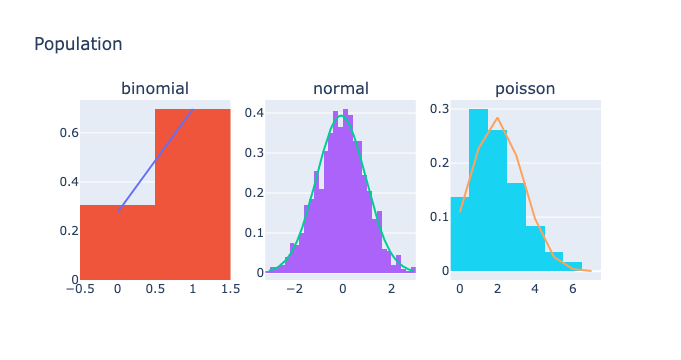

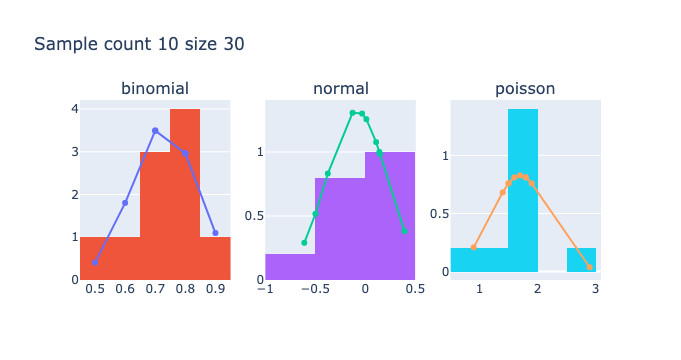

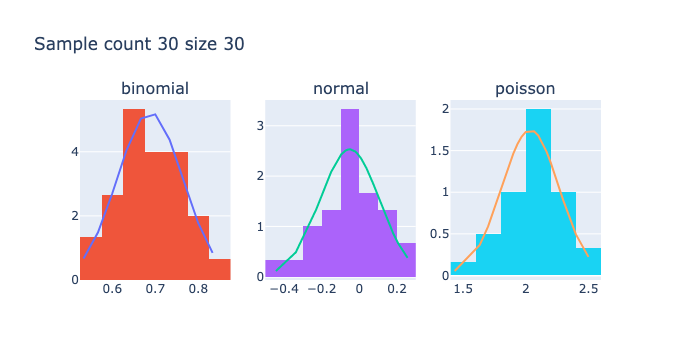

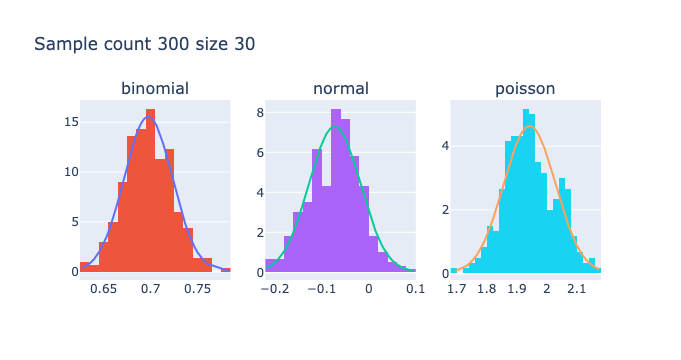

In [7]:
plot_histograms(pop_dict, 'Population').show()

sample_size = 30
sample_count_lst = [10, 30, 300]
for sample_count in sample_count_lst:
    sample_mean_dict = generate_sample_mean(pop_dict, sample_count, sample_size)
    plot_histograms(sample_mean_dict, f'Sample count {sample_count} size {sample_size}').show()

# sample_size_lst = [5, 10, 30, 100]
# for sample_size in sample_size_lst:
#     sample_mean_dict = generate_sample_mean(pop_dict, 200, sample_size)
#     plot_histograms(sample_mean_dict, f'Sample size {sample_size}').show()

#### Discussion

We see that sample histograms tend to look more normal as we increase the number of times we draw samples from the population. 

In [8]:
# import plotly.figure_factory as ff

# def plot_sample_distplots(sample_count: int, sample_size:int, title: str):

#     sample_mean_dict = generate_sample_mean(pop_dict, sample_count, sample_size)
    
#     hist_data = []
    
#     for key in sample_mean_dict.keys():
#         hist_data.append(sample_mean_dict[key]) 

#     group_labels = list(sample_mean_dict.keys())

#     # Create distplot with curve_type set to 'normal'
#     fig = ff.create_distplot(
#         hist_data, 
#         group_labels, 
#         show_hist=True, 
#         show_curve=True, 
#         histnorm='probability',
#         bin_size=0.1,
#     )

#     fig.update_layout(
#         title=title,
#     )
#     return fig

# sample_size = 5
# sample_count_lst = [10, 30, 300]
# for sample_count in sample_count_lst:
#     sample_mean_dict = generate_sample_mean(pop_dict, sample_count, sample_size)
#     plot_sample_distplots(sample_count, sample_size, f'Sample count {sample_count} size {sample_size}').show()


## Normality Tests

Histograms can be misleading. Plot QQ for more visual cue, and then 2 hypothesis tests for normality.

### QQ Plot

In [9]:
def get_qq_data(dist_dict: dict):
    qq_dict = dict()
    for key in dist_dict.keys(): 
        qq_dict[key] = qqplot(dist_dict[key], line='s').gca().lines;
    return qq_dict

In [10]:
%%capture
qq_pop_dict = get_qq_data(pop_dict)
qq_sample_dict = get_qq_data(sample_mean_dict)

In [11]:
def plot_qqplots(dist_dict: dict, title: str):
    fig = make_subplots(
        rows=1, cols=len(dist_dict.keys()), 
        shared_yaxes=False,
        subplot_titles=tuple(dist_dict.keys())
    )
    i = 1
    for key in dist_dict.keys(): 
        fig.add_trace(
            go.Scatter(
                x=dist_dict[key][0].get_xdata(),
                y=dist_dict[key][0].get_ydata(),
                mode='markers'
            ),
            row=1, col=i
        )
        fig.add_trace(
            go.Scatter(
                x=dist_dict[key][1].get_xdata(),
                y=dist_dict[key][1].get_ydata(),
            ),
            row=1, col=i
        )
        i += 1

    fig.update_layout(
        title=title,
        showlegend=False
    )
    return fig

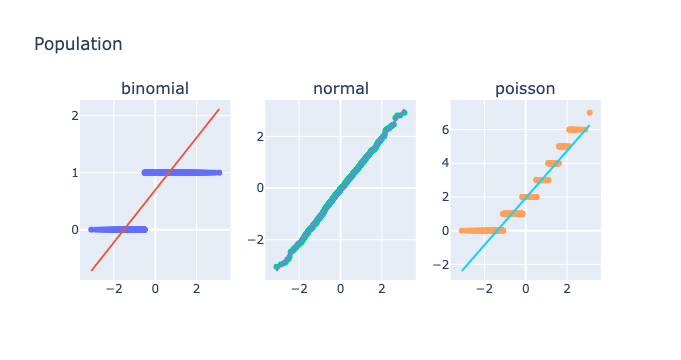

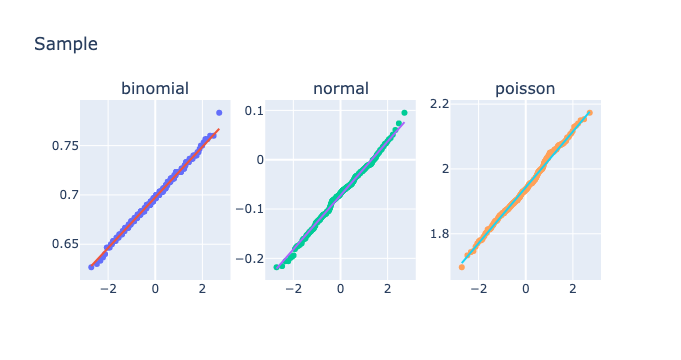

In [12]:
plot_qqplots(qq_pop_dict, 'Population').show()
plot_qqplots(qq_sample_dict, 'Sample').show()

### Shapiro-Wilk Test
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html

In [13]:
from scipy.stats import shapiro
    

In [14]:
def norm_shapiro_wilk(dist_dict: dict, title: str):
    
    print(f'''
    SHAPIRO-WILK {title}
    ''')
    
    sample_lst = []
    sample_length_lst = []
    t_stat_lst = []
    p_value_lst = []
    # alpha_lst = np.repeat(alpha, 3)
    alpha_lst = []
    msg_lst = []
    
    for key in dist_dict.keys():
        t_stat, p_value = shapiro(dist_dict[key])
        sample_lst.append(key)
        sample_length_lst.append(len(dist_dict[key]))
        t_stat_lst.append('{:.4f}'.format(t_stat))
        p_value_lst.append('{:.4f}'.format(p_value))
        
        
        alpha = 0.05
        alpha_lst.append(alpha)
        msg = ''
        if p_value > alpha:
            msg = "p>a, normal"
            msg_lst.append(msg)
        else:
            msg = "p<a, not normal"
            msg_lst.append(msg)
                 
    fig = go.Figure(
        go.Table(
            header=dict(
                values=[
                    'Sample',
                    'Count', 
                    'T Stat',
                    'P Value',
                    'Alpha',
                    'Interpret'
                ]
            ),
            cells=dict(
                values=[
                    sample_lst,
                    sample_length_lst,
                    t_stat_lst,
                    p_value_lst,
                    alpha_lst,
                    msg_lst
                ]
            ),
        )

    )
    return fig


    SHAPIRO-WILK Population
    


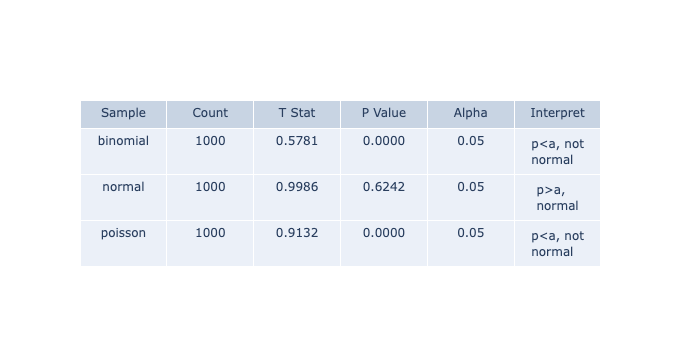


    SHAPIRO-WILK Sample
    


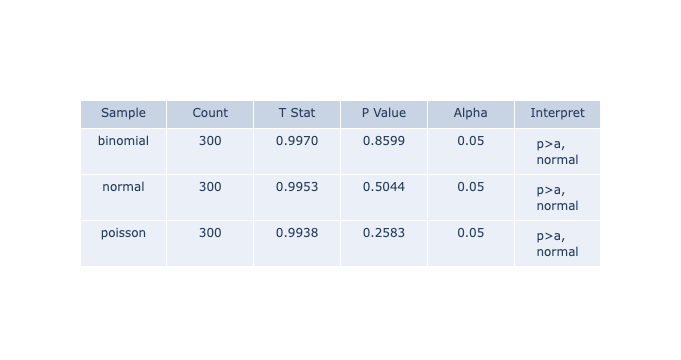

In [15]:
norm_shapiro_wilk(pop_dict, 'Population').show()
norm_shapiro_wilk(sample_mean_dict, 'Sample').show()

### Anderson-Darling

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html

In [16]:
from scipy.stats import anderson

In [17]:
def norm_anderson_darling(dist_dict: dict, title: str):
    
    for key in dist_dict.keys():
        result = anderson(dist_dict[key])
        
        sample_length_lst = np.repeat(len(dist_dict[key]), 5)
        t_stat_lst = np.repeat('{:.4f}'.format(result.statistic), 5)
        significance_lst = result.significance_level
        critical_lst = result.critical_values
        msg_lst = []
        
        for i in range(0, len(critical_lst)):
            if result.statistic < critical_lst[i]:
                msg = 't<crit, normal'
                msg_lst.append(msg)
            else:
                msg = 't>crit, not normal'
                msg_lst.append(msg)
                
        print(f'''
        ANDERSON-DARLING {title} {key}
        ''')
        fig = go.Figure(
            go.Table(
                header=dict(
                    values=[
                        # 'Sample',
                        'Count', 
                        'T Stat',
                        'Significance',
                        'Alpha',
                        'Interpret'
                    ]
                ),
                cells=dict(
                    values=[
                        # sample_lst,
                        sample_length_lst,
                        t_stat_lst,
                        significance_lst,
                        critical_lst,
                        msg_lst
                    ]
                ),
            )
        )
        fig.update_layout(height=500)
        fig.show()


        ANDERSON-DARLING Population binomial
        


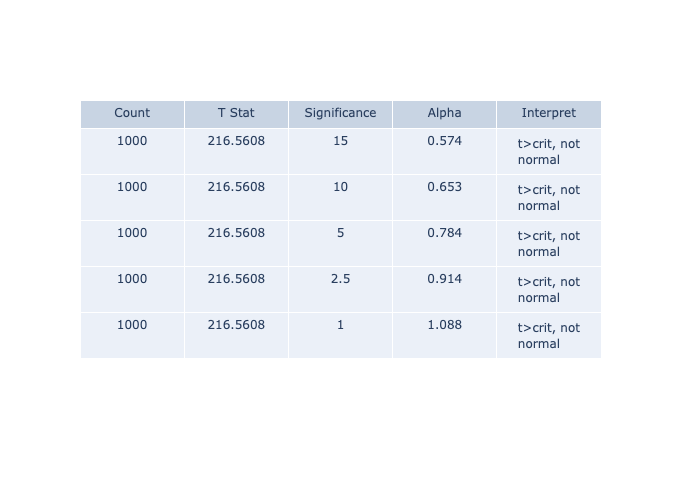


        ANDERSON-DARLING Population normal
        


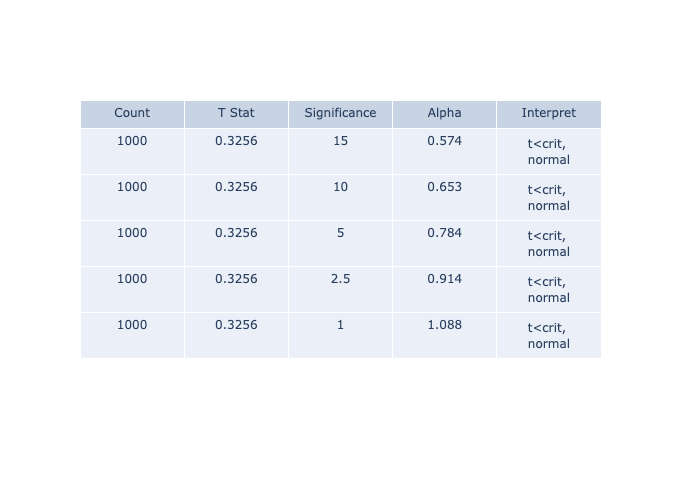


        ANDERSON-DARLING Population poisson
        


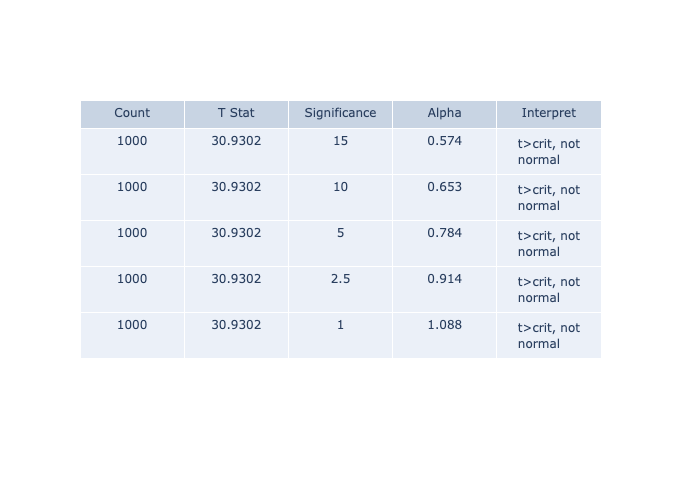


        ANDERSON-DARLING Sample binomial
        


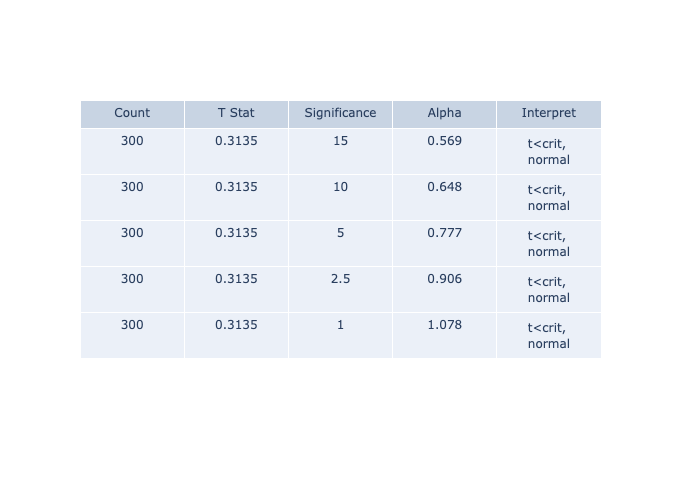


        ANDERSON-DARLING Sample normal
        


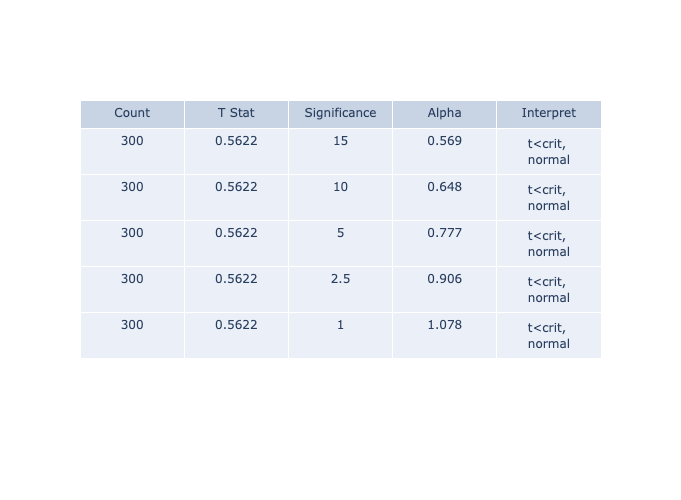


        ANDERSON-DARLING Sample poisson
        


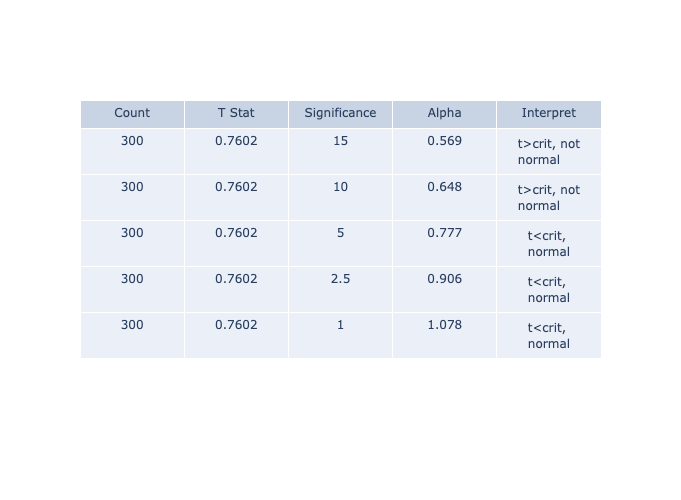

In [18]:
norm_anderson_darling(pop_dict, 'Population')
norm_anderson_darling(sample_mean_dict, 'Sample')